# Ventilation durations

Query based on the MIMIC ventilation-durations approach to generate a list of start and stop times for mechanical ventilation. 

Currently only looking at `hospitalid = 243`

### Invasive: 
- mean_airway_pressure 
- mv_mode (all simv; all prvc; ac; bi-vent;
- peak_pressure
- plateau_pressure
- ps
- rsbi

### Both invasive and non-invasive: 
- fio2
- mve
- peep

### Weaning trial:
- rsbi

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
from tableone import TableOne
%matplotlib inline

In [2]:
# Create a database connection
user = 'postgres'
host = 'localhost'
dbname = 'eicu'
schema = 'public, eicu_crd_phi'

In [3]:
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=user, host=host, 
                       password=getpass.getpass(prompt='Password:'.format(user)))
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema))

Password:········


## Build the ventilation-durations and end-of-life views

In [4]:
with open('./ventilation-durations.sql', 'r') as f:
    buildviews_vent = f.read()
cur.execute(buildviews_vent)

# Also interested in the following details in careplangeneral:
# - Do not resuscitate
# - Comfort measures only
# - End of life
# - Terminal

with open('./end-of-life.sql', 'r') as f:
    buildviews_eol = f.read()
cur.execute(buildviews_eol)

## Extract a dataset comprising ventdurations, end-of-life status, and apache scores

In [5]:
query = \
"""
WITH vent AS (
    SELECT v.*, 
           min(e.dnr_offset) AS dnr_offset_1st, 
           min(e.cmo_offset) AS cmo_offset_1st, 
           min(e.endoflife_offset) AS endoflife_offset_1st, 
           min(e.terminal_offset) AS terminal_offset_1st,
           min(e.bedside_trach_offset) AS bedside_trach_offset_1st,
           min(e.trach_acute_offset) AS trach_acute_offset_1st,
           min(e.trach_chronic_offset) AS trach_chronic_offset_1st
    FROM ventdurations v
    LEFT JOIN endoflife e
    ON v.patientunitstayid = e.patientunitstayid
    GROUP BY v.patientunitstayid, v.ventseq, v.startoffset, v.endoffset,
        v.ventilation_minutes)
SELECT v.*, v.ventilation_minutes/60 AS ventilation_hours,
       p.gender, p.age, p.ethnicity, p.patienthealthsystemstayid, p.uniquepid,
       CASE WHEN a.actualhospitalmortality like 'EXPIRED' THEN 1 ELSE 0 END AS hosp_mortality,
       a.actualhospitallos AS hosp_los
FROM vent v
LEFT JOIN patient p
ON v.patientunitstayid = p.patientunitstayid
LEFT JOIN apachepatientresult a
ON v.patientunitstayid = a.patientunitstayid AND a.apacheversion = 'IV'
ORDER BY v.patientunitstayid, v.ventseq;
"""

data = pd.read_sql_query(query,con)

In [6]:
data[data.hosp_mortality ==1].head()

,patientunitstayid,ventseq,startoffset,endoffset,ventilation_minutes,dnr_offset_1st,cmo_offset_1st,endoflife_offset_1st,terminal_offset_1st,bedside_trach_offset_1st,trach_acute_offset_1st,trach_chronic_offset_1st,ventilation_hours,gender,age,ethnicity,patienthealthsystemstayid,uniquepid,hosp_mortality,hosp_los
14,1434391,1,-5,2067,2072,NaN,NaN,NaN,NaN,None,NaN,NaN,34,Female,83,Caucasian,1097063,015-69540,1,11.2278
15,1434393,1,13,81,68,9983.0,NaN,NaN,NaN,None,NaN,NaN,1,Female,83,Caucasian,1097063,015-69540,1,11.2278
16,1434494,1,143,8990,8847,12077.0,NaN,NaN,NaN,None,NaN,NaN,147,Female,63,Caucasian,1097145,015-60017,1,18.6083
17,1434494,2,9563,10174,611,12077.0,NaN,NaN,NaN,None,NaN,NaN,10,Female,63,Caucasian,1097145,015-60017,1,18.6083
26,1434698,1,-4,4766,4770,NaN,NaN,NaN,NaN,None,NaN,NaN,79,Male,> 89,Caucasian,1097317,015-40413,1,4.2521


### Explore the ventilation durations data

In [15]:
# Create Table 1, stratified by hospital mortality
print('\nCharacteristics of the patient population, grouped \nby hospital mortality:')
columns = ['ventilation_hours','hosp_mortality','hosp_los','gender','ethnicity']
categorical = ['gender','ethnicity','hosp_mortality']
nonnormal = ['ventilation_hours']
groupby = ['hosp_mortality']
table = TableOne(data, columns=columns, categorical=categorical, nonnormal=nonnormal, 
                 groupby = groupby)
table.tableone


Characteristics of the patient population, grouped 
by hospital mortality:


isnull      hosp_mortality=0  \
variable          level                                           
n                                                          1156   
ethnicity         African American      0           368 (31.83)   
                  Asian                                7 (0.61)   
                  Caucasian                         735 (63.58)   
                  Other/Unknown                       46 (3.98)   
gender            Female                0           492 (42.56)   
                  Male                              663 (57.35)   
                  Other                                1 (0.09)   
hosp_los                              123         14.13 (11.08)   
hosp_mortality    0                     0          1156 (100.0)   
                  1                                               
ventilation_hours                       0    18.00 [7.00,54.00]   

                                        hosp_mortality=1  
variable          level                                   
n                                                    299  
ethnicity         African American            86 (28.76)  
                  Asian                         2 (0.67)  
                  Caucasian                  201 (67.22)  
                  Other/Unknown                10 (3.34)  
gender            Female                     140 (46.82)  
                  Male                       159 (53.18)  
                  Other                                   
hosp_los                                     8.58 (8.06)  
hosp_mortality    0                                       
                  1                          299 (100.0)  
ventilation_hours                   48.00 [17.00,110.50]

In [38]:
# Create Table 1, stratified by hospital mortality
print('\nCharacteristics of the patient population, grouped \nby ventilation sequence (for sequence 1 or 2 only):')
columns = ['ventilation_hours','hosp_mortality','hosp_los','gender','ethnicity', 'ventseq']
categorical = ['gender','ethnicity','hosp_mortality']
nonnormal = ['ventilation_hours']
groupby = ['ventseq']
table = TableOne(data.loc[(data.ventseq==1) | (data.ventseq==2)], 
                 columns=columns, categorical=categorical, nonnormal=nonnormal, groupby = groupby)
table.tableone


Characteristics of the patient population, grouped 
by ventilation sequence (for sequence 1 or 2 only):


isnull             ventseq=1  \
variable          level                                           
n                                                          1182   
ethnicity         African American      0           363 (30.71)   
                  Asian                                9 (0.76)   
                  Caucasian                         765 (64.72)   
                  Other/Unknown                       45 (3.81)   
gender            Female                0           492 (41.62)   
                  Male                              689 (58.29)   
                  Other                                1 (0.08)   
hosp_los                              111          10.72 (8.89)   
hosp_mortality    0                     0           930 (78.68)   
                  1                                 252 (21.32)   
ventilation_hours                       0    23.00 [8.00,67.50]   

                                             ventseq=2  
variable          level                                 
n                                                  164  
ethnicity         African American          53 (32.32)  
                  Asian                                 
                  Caucasian                 103 (62.8)  
                  Other/Unknown               8 (4.88)  
gender            Female                    79 (48.17)  
                  Male                      85 (51.83)  
                  Other                                 
hosp_los                                 19.05 (11.72)  
hosp_mortality    0                        134 (81.71)  
                  1                         30 (18.29)  
ventilation_hours                   22.00 [8.00,61.25]

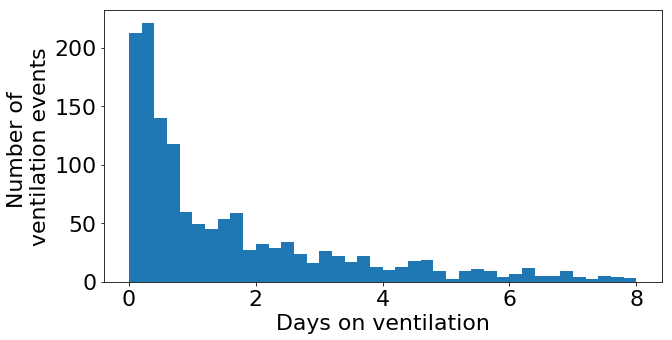

In [8]:
plt.figure(figsize=(10, 5))
plt.rcParams.update({'font.size': 22})
ax = plt.hist(data.ventilation_hours.values/24, bins=40, range=(0, 8))
plt.xlabel('Days on ventilation', fontsize=22)
plt.ylabel('Number of \nventilation events', fontsize=22)

## Notes on `careplangeneral` table

Useful to cross reference following rows in the `cplitemvalue` column:

- Ventilated - chronic dependency
- Ventilated - rapid wean/extubation
- Ventilated - with daily extubation evaluation
- Ventilated - with no daily extubation trial
- Ventilator bundle
- Ventilator wean
- Not intubated/normal airway
- Not intubated/partial airway obstruction
- Intubated/nasal ETT
- Intubated/nasal ETT - difficult
- Intubated/oral ETT
- Intubated/oral ETT - difficult
- Intubated/trach-acute
- Intubated/trach-chronic
- Non-invasive ventilation
- Open to air
- Respiratory Issue

In [9]:
data.to_csv('./hospital_243_vent.csv', index=False)